#### Trying multiscale hierarchy with thre gaussian means repeating. 
Not working as anticipated. Even untrained network can segment the two tasks at both levels

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
import os, sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')

import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size'] = 8
# mpl.rcParams['font.family'] = 'serif'
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

import utils.plot_utils as pltu
from logger import *
from utils.plot_utils import *
from plot_functions import *
from configs import *
from models.model_lstm import *
# import tasks.generative_1d
from tasks.hierarchical_gaussians_task import *
from train import *
# from plot_functions import plot_behavior_novel_contexts, plot_histograms_novel_contexts
# from plot_functions import plot_combined_behavior_and_histograms
from plot_functions import *

default_mean1 = 0.3
default_mean2 = 0.7
default_std = 0.1
default_std_novel = 0.2
means = np.array(list(range(-2, 13)))/10
stds = [0.1, 0.2, 0.3, 0.4, 0.5]


# Short horizon untrained

In [3]:
def plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf):
    # now get the gradients from the memory buffer
    grads = np.stack(testing_memory_buffer.timestep_data['thalamus_grad'])
    grads = grads.squeeze()[:, 0] # take only one unit grads
    grads[0] = 0 # first value is padded with a nan
    centered_grads = grads - np.mean(grads)

    # get the obs from the memory buffer
    obs = testing_memory_buffer.timestep_data['obs']
    obs = np.array(obs)

    env_key = testing_memory_buffer.timestep_data['context_names']
    means = []
    for env_key in testing_memory_buffer.timestep_data['context_names']:
        mean = testing_env.envs[env_key]['kwargs']['mean']
        means.append(mean)
    means = np.array(means)

    max_trials = config.training_phases[0]['config']['max_trials_per_block']

    context2 = np.zeros(len(obs))
    # context2 is 1 for indices from 0 to 3*max_trials trials and the -1 from 3*max_trials trials to 6*max_trials trials and so on
    for i in range(len(context2)):
        if i//(3*max_trials) % 2 == 0:
            context2[i] = 1
        else:
            context2[i] = -1
    # the very first block is a special case, choosen always to be 20 and does not belong to any of the two sequences
    # append 20 -1s to the beginning of the context2 and then remove the last 20 elements
    context2 = np.concatenate([np.ones(20)*-1, context2])
    context2 = context2[:-20]

    # Now that I have the grads in a vector, I want to check their modulation by context2 array vs means array, using something similar to the analysis below:

    centered_grads = grads - np.mean(grads)
    centered_means = means-np.mean(means)
    grads_modulation_by_context2 = np.dot(context2-np.mean(context2), centered_grads)/ len(context2) # 
    grads_modulation_by_context2 = np.abs(grads_modulation_by_context2)

    grads_modulation_by_means = np.dot(centered_means, centered_grads)/ len(means) #
    grads_modulation_by_means = np.abs(grads_modulation_by_means)

    grads_corr_by_context2 = np.abs(np.corrcoef(grads, context2)[0][1])
    grads_corr_by_means = np.abs(np.corrcoef(grads, means)[0][1])


    # bar plot the modulation
    fig, axes = plt.subplots(3,1, figsize=(8,6))
    ax = axes[0]
    ax.bar([0,1], [grads_modulation_by_context2, grads_modulation_by_means])
    ax.bar([2,3], [grads_corr_by_context2, grads_corr_by_means], color='orange')
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(['Context2', 'Means', 'cov_cxt2', 'cov_means'])
    ax.set_ylabel('Modulation')
    ax.set_xlabel('Variable')

    # plot centered grads overlaid on centered means
    # ax.plot(centered_grads, label='grads')
    ax = axes[1]
    ax.plot(centered_means, label='means')
    ax.axhline(0, color='k', linestyle='--', linewidth=0.5)
    ax.set_ylabel('Context1')
    ax.set_xlabel('Trials')
    # centered_grads have a very different scale, plot them on a second axis
    ax2 = ax.twinx()
    ax2.plot(centered_grads, label='grads', color='orange')
    ax2.set_ylabel('Grads')
    ax2.spines['right'].set_color('orange')
    ax.legend()

    # plot centered grads overlaid on centered context2
    ax = axes[2]
    ax.plot(context2-np.mean(context2), label='context2')
    ax.axhline(0, color='k', linestyle='--', linewidth=0.5)
    ax.set_ylabel('Context2')
    ax.set_xlabel('Trials')
    # centered_grads have a very different scale, plot them on a second axis
    ax2 = ax.twinx()
    ax2.plot(centered_grads, label='grads', color='orange')
    ax2.set_ylabel('Grads')
    ax2.spines['right'].set_color('orange')
    ax2.legend()
    ax.legend()


### Checking old tasks for optim dynamcis

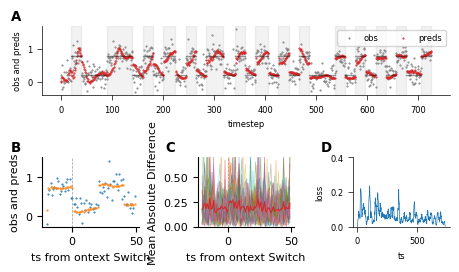

In [7]:
# Initiate and maybe Train RNN 
train_model = True
horizon_long_short = 'short'
# horizon_long_short = 'long'
scale = 10
experiment = 1
config = Config()
config.default_std = default_std
training_phase_1_config = {'context_transition_function': 'geometric', #'fixed_random_sequences',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks':30}
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
logger = Logger(config)
env = Generative_environment(config, experiment=experiment)
model = LSTM_model(config,hidden_size=100)
if horizon_long_short == 'long':
        horizon = training_phase_1_config['max_trials_per_block'] * (1+1)
else:
        horizon = 5
_use_oracle = True
_use_optimized_thalamus = False
if train_model:
        memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, 'WU', horizon, nn.MSELoss(), 0, logger)
        plot_behavior(memory_buffer, env, losses, config, _use_oracle )



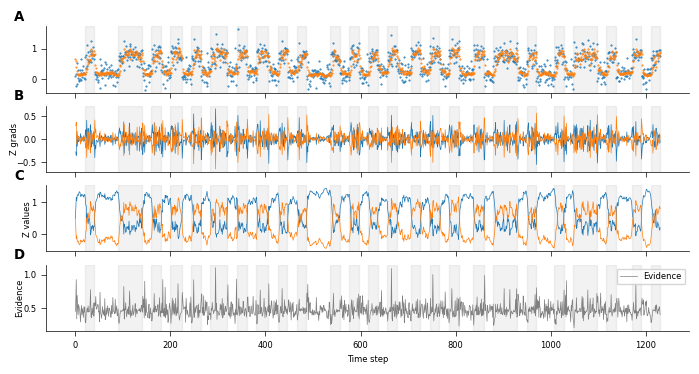

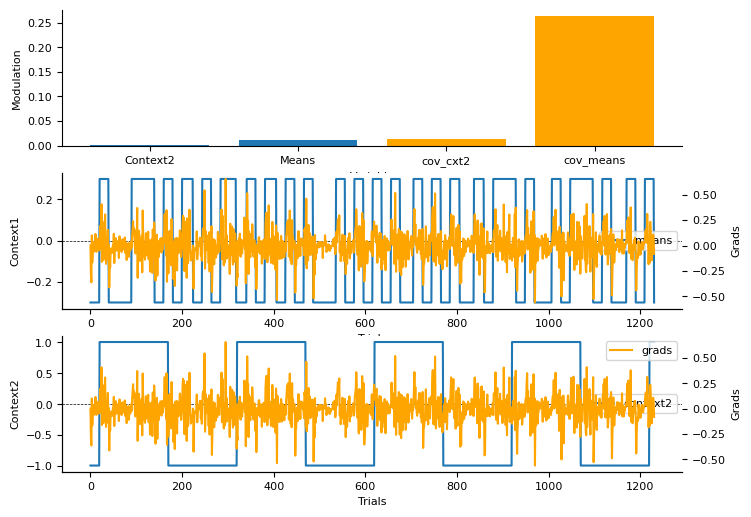

In [8]:
# Get thalamus initial inference values
horizon_long_short = 'short'
config.training_phases[0]['config']['no_of_blocks'] = 50
testing_env = Generative_environment(config, experiment=experiment)

if horizon_long_short == 'long':
        horizon = int(training_phase_1_config['max_trials_per_block'] * (1+1))
else:
        horizon = 5
# optimizer = torch.optim.SGD([model.get_parameter('thalamus')], lr=.30, momentum=0.5)
optimizer = 'LU'
logger = Logger(config)
config.momentum = 0.1
config.LU_lr = 1
criterion = nn.MSELoss(reduction='sum')
_use_oracle = False
_use_optimized_thalamus = True
config.backprop_only_last_timestep = False
testing_memory_buffer, testing_losses = adapt_model_v3(model, testing_env, _use_oracle, config, optimizer, horizon, criterion,
                                                0, logger, _use_optimized_thalamus=_use_optimized_thalamus,)
plot_grads(testing_memory_buffer, testing_env, x1=50, x2=np.inf)

prespecified_thalamus = np.stack(testing_memory_buffer.timestep_data['thalamus'])

plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf)

In [6]:
# Get thalamus initial inference values
horizon_long_short = 'long'
config.training_phases[0]['config']['no_of_blocks'] = 50
testing_env = Generative_environment(config, experiment=experiment)

if horizon_long_short == 'long':
        horizon = int(training_phase_1_config['max_trials_per_block'] * (1+1))
else:
        horizon = 5
optimizer = 'LU'
logger = Logger(config)
criterion = nn.MSELoss(reduction='sum')
_use_optimized_thalamus = False
config.backprop_only_last_timestep = True
testing_memory_buffer, testing_losses = adapt_model_v3(model, testing_env, _use_oracle, config, optimizer, horizon, criterion,
                                                0, logger, _use_optimized_thalamus=_use_optimized_thalamus,)
plot_grads(testing_memory_buffer, testing_env, x1=50, x2=np.inf)

prespecified_thalamus_last_only = np.stack(testing_memory_buffer.timestep_data['thalamus'])

plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf)

NameError: name 'ts_in_training' is not defined

Text(0, 0.5, 'Thalamus')

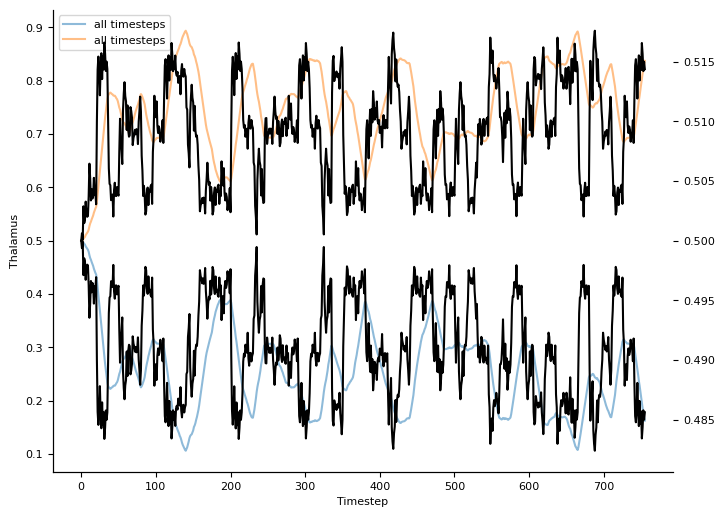

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(8,6))
axes.plot(prespecified_thalamus.squeeze(), label='all timesteps', alpha=0.5)
axes2 = axes.twinx()
axes2.plot(prespecified_thalamus_last_only.squeeze(), label='last timestep', color='black')
axes.legend()
axes.set_xlabel('Timestep')
axes.set_ylabel('Thalamus')


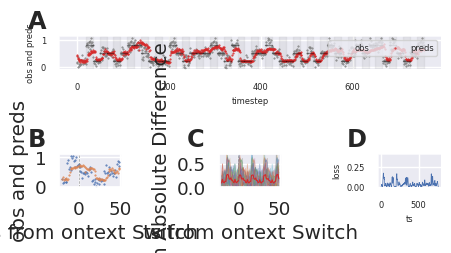

In [ ]:
# now train again with the thalamus values prespecified
env = Generative_environment(config, experiment=experiment) # the same env with the same config.seed, so the data will be the same
logger = Logger(config) # clear the logger
weights = [p for n,p in model.named_parameters() if n !='thalamus']
# weights = weights + [model.get_parameter('thalamus')]
WU_optimizer = optim.Adam(weights, lr=0.001)
ts_in_training= 0
if horizon == 'long':
        horizon = training_phase_1_config['max_trials_per_block'] * (1+1)
else:
        horizon = 5
memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, WU_optimizer, horizon, nn.MSELoss(), ts_in_training, logger,
        # prespecified_thalamus=prespecified_thalamus, input_distort=True)
        prespecified_thalamus=(prespecified_thalamus-0.5 )*10, input_distort=True)
plot_behavior(memory_buffer, env, losses, config, _use_oracle,)


# Putting it all together

In [ ]:
def get_correlations(testing_memory_buffer, testing_env, config):
    # get the thalamus activity from the memory buffer
    thalamus = np.stack(testing_memory_buffer.timestep_data['thalamus'])
    thalamus = thalamus.squeeze()[:, 0] # take only one unit 

    # get the obs from the memory buffer
    obs = testing_memory_buffer.timestep_data['obs']
    obs = np.array(obs)

    env_key = testing_memory_buffer.timestep_data['context_names']
    means = []
    for env_key in testing_memory_buffer.timestep_data['context_names']:
        mean = testing_env.envs[env_key]['kwargs']['mean']
        means.append(mean)
    means = np.array(means)

    max_trials = config.training_phases[0]['config']['max_trials_per_block']

    context2 = np.zeros(len(obs))
    # context2 is 1 for indices from 0 to 3*max_trials trials and the -1 from 3*max_trials trials to 6*max_trials trials and so on
    for i in range(len(context2)):
        if i//(3*max_trials) % 2 == 0:
            context2[i] = 1
        else:
            context2[i] = -1
    # the very first block is a special case, choosen always to be 20 and does not belong to any of the two sequences
    # append 20 -1s to the beginning of the context2 and then remove the last 20 elements
    context2 = np.concatenate([np.ones(20)*-1, context2])
    context2 = context2[:-20]

    # calculate the correlation between thalamus and context2
    corr_thalamus_context2 = np.corrcoef(thalamus, context2)[0][1]

    # calculate the correlation between thalamus and means
    corr_thalamus_means = np.corrcoef(thalamus, means)[0][1]

    return corr_thalamus_context2, corr_thalamus_means

In [ ]:
# Initiate RNN and config 
loss_means = []
corr_Thalamus_context2s = []
corr_Thalamus_meanss = []
prespecified_thalamus_values = []

plot_plots = False
# horizon_long_short = 'short'
horizon_long_short = 'long'
input_distort=False
scale = 3
experiment = 8
config = Config()
config.default_std = default_std
training_phase_1_config = {'context_transition_function':'fixed_random_sequences',
        'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
        'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks':50}
config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
model = LSTM_model(config,hidden_size=100)
weights = [p for n,p in model.named_parameters() if n !='thalamus']
WU_optimizer = optim.Adam(weights, lr=0.001)
LU_optimizer = torch.optim.SGD([model.get_parameter('thalamus')], lr=.30, momentum=0.5)
ts_in_training= 0
if horizon_long_short == 'long':
        horizon = training_phase_1_config['max_trials_per_block'] * (1+1+1)
else:
        horizon = 5
_use_oracle = False
_use_optimized_thalamus = False

for iteration in (range(3)):
        # print('running iteration: ', iteration)
        logger = Logger(config)
        env = Generative_environment(config, experiment=experiment)
        # Get latent inference values
        config.training_phases[0]['config']['no_of_blocks'] = 50
        testing_env = Generative_environment(config, experiment=experiment)
        logger = Logger(config)
        criterion = nn.MSELoss(reduction='sum')
        _use_optimized_thalamus = False
        testing_memory_buffer, testing_losses = adapt_model_v3(model, testing_env, _use_oracle, config, LU_optimizer, horizon, criterion,
                                                        ts_in_training, logger, _use_optimized_thalamus=_use_optimized_thalamus,)
        if plot_plots: plot_grads(testing_memory_buffer, testing_env, x1=50, x2=np.inf)
        plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf)
        prespecified_thalamus = np.stack(testing_memory_buffer.timestep_data['thalamus'])
        # These were already softmaxed. but I want to softmax them with a lower temperature
        prespecified_thalamus_values.append(prespecified_thalamus)
        prespecified_thalamus = prespecified_thalamus - np.mean(prespecified_thalamus)
        prespecified_thalamus = prespecified_thalamus * 10 # hacky way to amplify the values otherwise their take too long to learn.
        # prespecified_thalamus = F.softmax(torch.tensor(prespecified_thalamus), dim=0, ).numpy()

        corr_Thalamus_context2, corr_Thalamus_means = get_correlations(testing_memory_buffer, testing_env, config)
        corr_Thalamus_context2s.append(corr_Thalamus_context2)
        corr_Thalamus_meanss.append(corr_Thalamus_means)
        # now train again with the thalamus values prespecified
        env = Generative_environment(config, experiment=experiment) # the same env with the same config.seed, so the data will be the same
        logger = Logger(config) # clear the logger
        weights = [p for n,p in model.named_parameters() if n !='thalamus']
        # weights = weights + [model.get_parameter('thalamus')]
        WU_optimizer = optim.Adam(weights, lr=0.001)
        ts_in_training= 0
        if horizon == 'long':
                horizon = training_phase_1_config['max_trials_per_block'] * (1+1)
        else:
                horizon = 5
        memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, WU_optimizer, horizon, nn.MSELoss(), ts_in_training, logger,
                prespecified_thalamus=prespecified_thalamus, input_distort=input_distort)
                # prespecified_thalamus=(prespecified_thalamus-0.5 )*10, input_distort=True)
        loss_means.append(np.mean(losses))
        if plot_plots: plot_behavior(memory_buffer, env, losses, config, _use_oracle,)

fig, axes = plt.subplots(1,2, figsize=(8,2))
ax = axes[0]
ax.plot(loss_means)
ax.set_ylabel('Loss')
ax.set_xlabel('Iteration')
ax = axes[1]
ax.plot(corr_Thalamus_context2s, label='context2')
ax.plot(corr_Thalamus_meanss, label='means')
ax.set_ylabel('Correlation')
ax.set_xlabel('Iteration')
ax.legend()
plt.tight_layout()

fig, ax = plt.subplots(1,1, figsize=(9,3))
# plot each vector of thalamus values with viridis color gradations
for i in range(len(prespecified_thalamus_values)):
        ax.plot(prespecified_thalamus_values[i].squeeze()[:,0], color=plt.cm.viridis(i/len(prespecified_thalamus_values)), label=f'iter {i}')
ax.set_ylabel('Thalamus')
ax.set_xlabel('Trials')
ax.legend()


NameError: name 'Config' is not defined

In [ ]:
def train_and_test_model(experiment, default_std, train_model = False, horizon = 'long', scale=3, prespecified_thalamus=None):
        # Train RNN
        config = Config()
        config.default_std = default_std
        training_phase_1_config = {'context_transition_function':'fixed_random_sequences',
                'max_trials_per_block':int(scale*5), 'min_trials_per_block':int(scale*2),
                'context_switch_rate': 1/(scale*(5-3)), 'no_of_blocks':800}
        config.training_phases= [{'start_ts': 1, 'config': training_phase_1_config}]
        logger = Logger(config)
        env = Generative_environment(config, experiment=experiment)
        model = LSTM_model(config,hidden_size=100)
        weights = [p for n,p in model.named_parameters() if n !='thalamus']
        # weights = weights + [model.get_parameter('thalamus')]
        WU_optimizer = optim.Adam(weights, lr=0.001)
        ts_in_training= 0
        if horizon == 'long':
                horizon = training_phase_1_config['max_trials_per_block'] * (1+1)
        else:
                horizon = 5
        _use_oracle = False
        
        if train_model:
                memory_buffer, losses = adapt_model_v3(model, env, _use_oracle, config, WU_optimizer, horizon, nn.MSELoss(), ts_in_training, logger)
                plot_behavior(memory_buffer, env, losses, config, _use_oracle )

        # Testing and plotting
        config.training_phases[0]['config']['no_of_blocks'] = 50
        testing_env = Generative_environment(config, experiment=experiment)

        # horizon = 5
        optimizer = torch.optim.SGD([model.get_parameter('thalamus')], lr=.30, momentum=0.5)
        logger = Logger(config)
        criterion = nn.MSELoss(reduction='sum')
        _use_oracle = False
        _use_optimized_thalamus = False
        testing_memory_buffer, testing_losses = adapt_model_v3(model, testing_env, _use_oracle, config, optimizer, horizon, criterion,
                                                        ts_in_training, logger, _use_optimized_thalamus=_use_optimized_thalamus,
                                                        prespecified_thalamus=prespecified_thalamus)
        if train_model:                                       
                plot_behavior_simple(memory_buffer, env, losses, config, _use_oracle, testing_memory_buffer, testing_env)
        else: # just replace with testing results
                plot_behavior_simple(testing_memory_buffer, testing_env, testing_losses, config, _use_oracle, testing_memory_buffer, testing_env)
        plot_grads(testing_memory_buffer, testing_env, x1=50, x2=np.inf)
        # plt.savefig(f'./exports/Cortex_only_CL_behavior.pdf')
        return (testing_memory_buffer, testing_env, testing_losses, config)

In [ ]:
train_model = True
horizon = 'long'
testing_memory_buffer2, testing_env2, testing_losses2, config = train_and_test_model(experiment=8, default_std=default_std, train_model = train_model, horizon = horizon, scale=3,
prespecified_thalamus=np.stack(testing_memory_buffer.timestep_data['thalamus']))
plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf)


KeyboardInterrupt: 

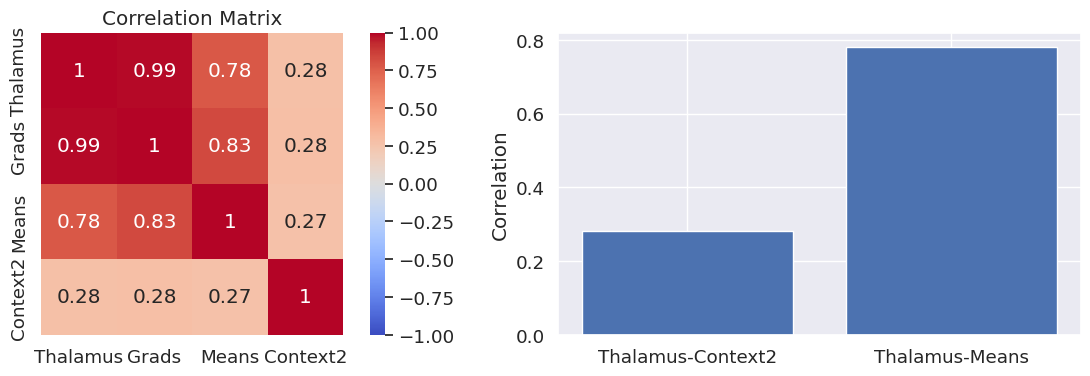

In [ ]:
# Plotting the entire corr matrix for the variables for complete checks
thalamus = np.stack(testing_memory_buffer.timestep_data['thalamus'])
thalamus = thalamus.squeeze()[:, 0] # take only one unit 

grads = np.stack(testing_memory_buffer.timestep_data['thalamus_grad'])
grads = grads.squeeze()[:, 1] # take only one unit grads
grads[0] = 0 # first value is padded with a nan

# get the obs from the memory buffer
obs = testing_memory_buffer.timestep_data['obs']
obs = np.array(obs)

env_key = testing_memory_buffer.timestep_data['context_names']
means = []
for env_key in testing_memory_buffer.timestep_data['context_names']:
    mean = testing_env.envs[env_key]['kwargs']['mean']
    means.append(mean)
means = np.array(means)

max_trials = config.training_phases[0]['config']['max_trials_per_block']

context2 = np.zeros(len(obs))
# context2 is 1 for indices from 0 to 3*max_trials trials and the -1 from 3*max_trials trials to 6*max_trials trials and so on
for i in range(len(context2)):
    if i//(3*max_trials) % 2 == 0:
        context2[i] = 1
    else:
        context2[i] = -1
# the very first block is a special case, choosen always to be 20 and does not belong to any of the two sequences
# append 20 -1s to the beginning of the context2 and then remove the last 20 elements
context2 = np.concatenate([np.ones(20)*-1, context2])
context2 = context2[:-20]

# plot the correlation matrix amongst means, context2, thalamus
import seaborn as sns

# calculate the correlation matrix
corr_matrix = np.corrcoef([thalamus, grads, means, context2])

# plot the correlation matrix
sns.set(font_scale=1.2)
fig, axes = plt.subplots(1,2,figsize=(12, 4), dpi=100)
ax = axes[0]
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, ax=ax)
ax.set_xticklabels(['Thalamus', 'Grads', 'Means', 'Context2'])
ax.set_yticklabels(['Thalamus', 'Grads', 'Means', 'Context2'])
ax.set_title('Correlation Matrix')
ax = axes[1]
corr_Thalamus_context2 = np.corrcoef(thalamus, context2)[0][1]
corr_Thalamus_means = np.corrcoef(thalamus, means)[0][1]
ax.bar([0,1], [corr_Thalamus_context2, corr_Thalamus_means])
ax.set_xticks([0,1])
ax.set_xticklabels(['Thalamus-Context2', 'Thalamus-Means'])
ax.set_ylabel('Correlation')
fig.tight_layout()


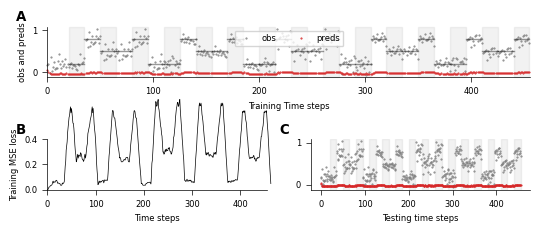

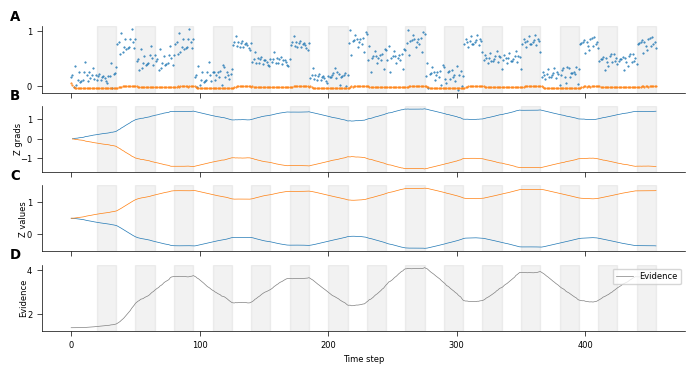

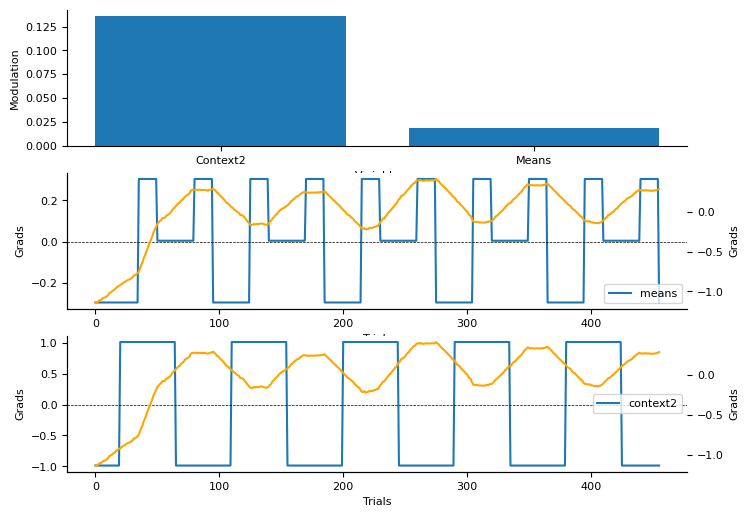

In [ ]:
train_model = False
horizon = 'long'
testing_memory_buffer, testing_env, testing_losses, config = train_and_test_model(experiment=7, default_std=default_std, train_model = train_model, horizon = horizon, scale=3)
plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf)
plt.savefig(f'./exports/block_gaussians_modulations_train_{train_model}_horizon_{horizon}.pdf')

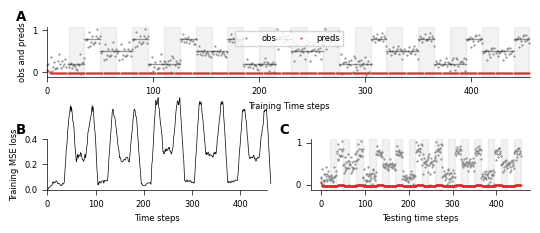

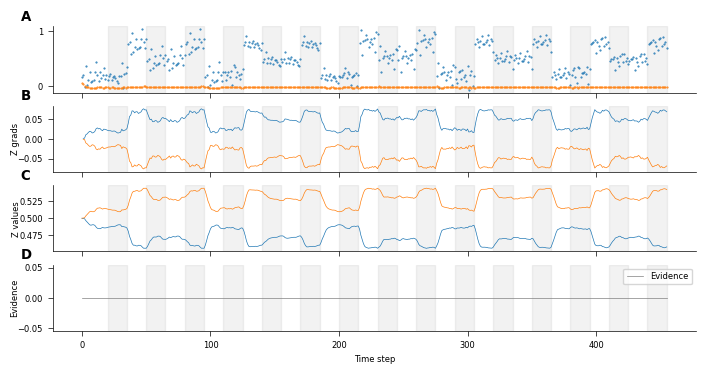

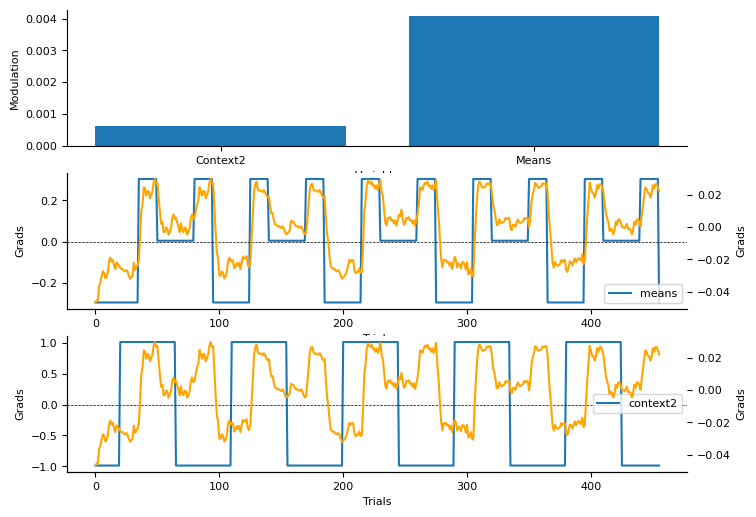

In [ ]:
train_model = False
horizon = 'short'
testing_memory_buffer, testing_env, testing_losses, config = train_and_test_model(experiment=7, default_std=default_std, train_model = train_model, horizon = horizon, scale=3)
plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf)
plt.savefig(f'./exports/block_gaussians_modulations_train_{train_model}_horizon_{horizon}.pdf')

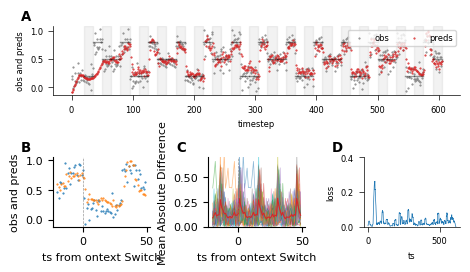

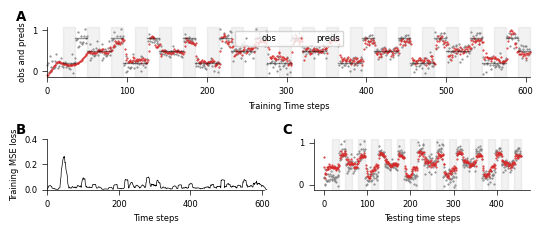

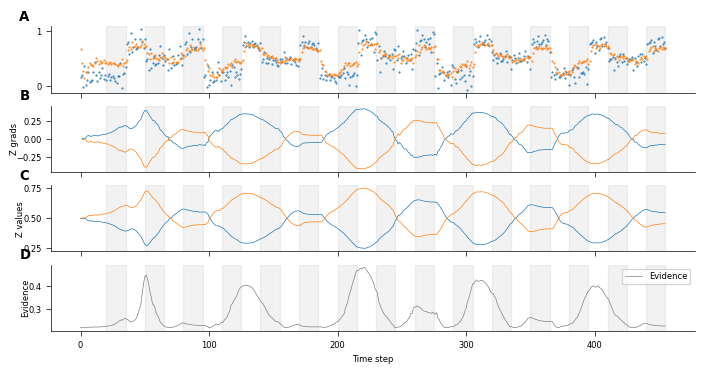

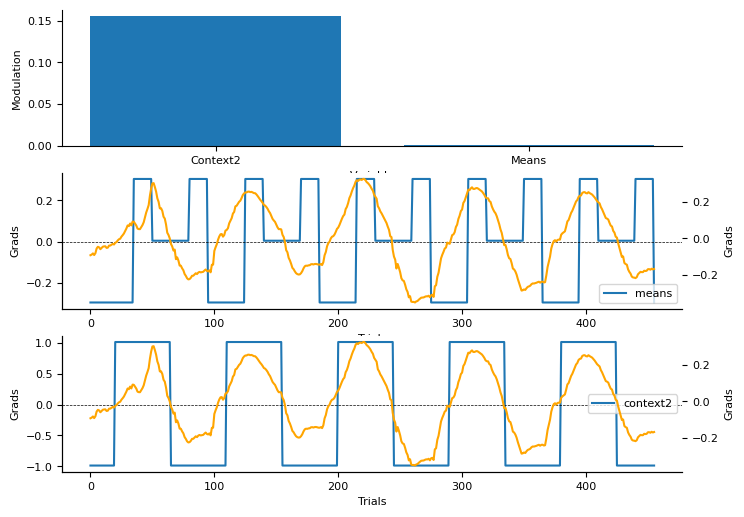

In [ ]:
train_model = True
horizon = 'long'
testing_memory_buffer, testing_env, testing_losses, config = train_and_test_model(experiment=7, default_std=default_std, train_model = train_model, horizon = horizon, scale=3)
plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf)
plt.savefig(f'./exports/block_gaussians_modulations_train_{train_model}_horizon_{horizon}.pdf')

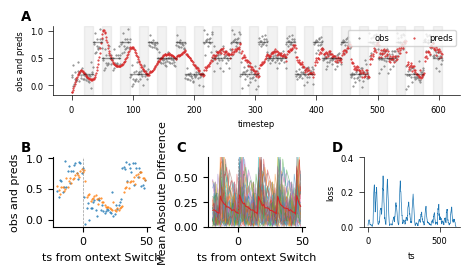

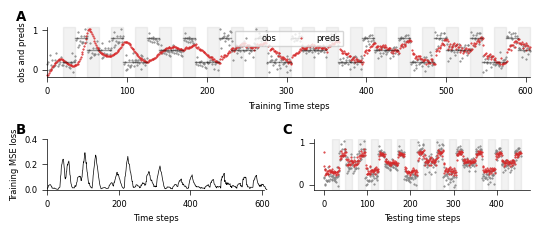

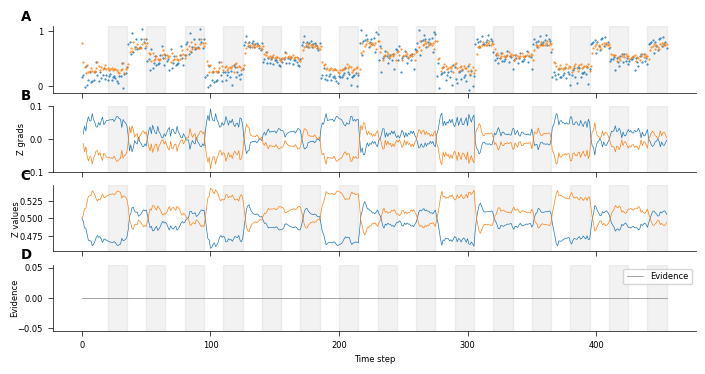

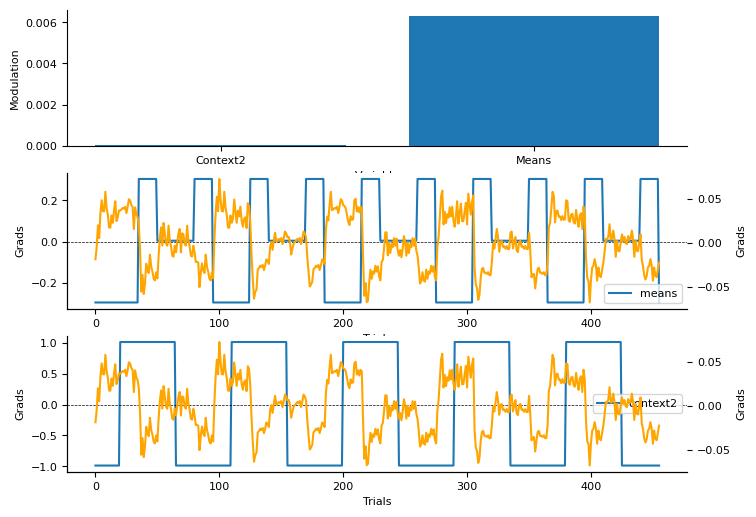

In [ ]:
train_model = True
horizon = 'short'
testing_memory_buffer, testing_env, testing_losses, config = train_and_test_model(experiment=7, default_std=default_std, train_model = train_model, horizon = horizon, scale=3)
plot_modulations(testing_memory_buffer, testing_env, testing_losses, config, x1=50, x2=np.inf)
plt.savefig(f'./exports/block_gaussians_modulations_train_{train_model}_horizon_{horizon}.pdf')